<h1><strong>Program to perfom text analytics, NLP, Sentiment Analysis on the drug reviews</strong></h1>

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import re
import logging

# Set the jupyter notebook options to display more text 
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Read the tsv with training data and testing data 
df_train = pd.read_table("drugsCom_raw\drugsComTrain_raw.tsv")
df_test = pd.read_table("drugsCom_raw\drugsComTest_raw.tsv")

df = pd.concat([df_train, df_test])

In [3]:
df.head(2)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null float64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [5]:
# Rename the unnamed column to ID column
df = df.rename(columns={'Unnamed: 0':'id'})

# Number of duplicates in review column 
dups = df['review'].duplicated().sum()
print("Duplicate rows in 'review' column : ", dups)

Duplicate rows in 'review' column :  86585


In [6]:
# Define a function to create a label column creating 3 bins (negative, neutral and positive) for all ratings
def get_label(rating):
    if rating <= 3:
        return -1 
    elif rating >= 7:
        return 1
    else:
        return 0

df['label'] = df['rating'].apply(lambda x: get_label(x))
df.head(2)

,id,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9.0,"May 20, 2012",27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8.0,"April 27, 2010",192,1


In [38]:
# Define a function to create a target column creating 3 bins (negative, neutral and positive) for all ratings
def get_target(rating):
    if rating <= 3:
        return "Negative" 
    elif rating >= 7:
        return "Neutral"
    else:
        return "Positive"

df['target'] = df['rating'].apply(lambda x: get_target(x))
df.head(2)

,id,drugName,condition,review,rating,date,usefulCount,label,reivew,name,target
0,206461,valsartan,Left Ventricular Dysfunction,It has no side effect I take it in combination of Bystolic Mg and Fish Oil,9.0,"May 20, 2012",27,1,it has no side effect i take it in combination of bystolic mg and fish oil,[valsartan],Neutral
1,95260,guanfacine,ADHD,My son is halfway through his fourth week of Intuniv We became concerned when he began this last week when he started taking the highest dose he will be on For two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him I called his doctor on Monday morning and she said to stick it out a few days See how he did at school and with getting up in the morning The last two days have been problem free He is MUCH more agreeable than ever He is less emotional a good thing less cranky He is remembering all the things he should Overall his behavior is better We have tried many different medications and so far this is the most effective,8.0,"April 27, 2010",192,1,my son is halfway through his fourth week of intuniv we became concerned when he began this last week when he started taking the highest dose he will be on for two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vacation very unusual for him i called his doctor on monday morning and she said to stick it out a few days see how he did at school and with getting up in the morning the last two days have been problem free he is much more agreeable than ever he is less emotional a good thing less cranky he is remembering all the things he should overall his behavior is better we have tried many different medications and so far this is the most effective,[guanfacine],Neutral


In [39]:
# Get the total values for each lable
df['label'].value_counts()

 1    142306
-1     46901
 0     25856
Name: label, dtype: int64

Text(0.5, 1.0, 'Dataset sentiment distribution')

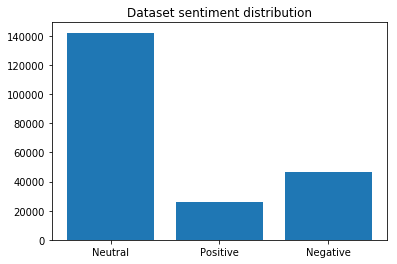

In [40]:
# Dataset label distribution
%matplotlib inline

from collections import Counter
target_cnt = Counter(df.target)

plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset sentiment distribution")

<h2><strong>Implementing NLP</strong></h2>
<h3><strong>Implementing TF IDF Vectorizer with Decision Trees and Random Forests</strong></h3>


In [16]:
%%time

# Perform some basic cleansing
rx_pat = r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(&quot;)|(\d\s)|(\d)|(\/)"
rx_pat_wSpace = r"(\-)|(\\)|(\s{2,})"
    
df['review'].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
df['review'].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
df['reivew'] = df.review.str.lower()

print(df.review.head(3))

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    It has no side effect I take it in combination of Bystolic Mg and Fish Oil
1    My son is halfway through his fourth week of Intuniv We became concerned when he began this last week when he started taking the highest dose he will be on For two days he could hardly get out of bed was very cranky and slept for nearly hours on a drive home from school vaca

In [11]:
%%time 

# Remove the common words and drug names from the reviews
# Download from 
# https://raw.githubusercontent.com/first20hours/google-10000-english/master/20k.txt

words_common = "20k.txt"

words_common = [line.strip() for line in open("20k.txt", 'r')]
print ("loaded words_common")

loaded words_common
Wall time: 35 ms


In [19]:
# Import NLTK stopwords. 
import nltk

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fbazil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Create a custom drugnames stopwords list. 

# Unique list with all drug names by frequency
drugs = df["drugName"].value_counts()

# Cleanse the drugName column
df["drugName"].replace(regex=True,inplace=True,to_replace=rx_pat, value=r'')
df["drugName"].replace(regex=True,inplace=True,to_replace=rx_pat_wSpace, value=r' ')
df["drugName"] = df["drugName"].str.lower()


In [23]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

# Tokenize names and combine in
df['name'] = df["drugName"].apply(tokenizer.tokenize)
drugs = [word for tokens in df['name'] for word in tokens]
print("Tokenized: ",len(drugs))


# Check drug names and remove any common words (google 20k most common)
drugs_cleaned = [token for token in drugs if token not in words_common]
print("Cleaned: ",len(drugs_cleaned))


Tokenized:  288027
Cleaned:  239131


In [25]:
drugs = pd.DataFrame(drugs_cleaned, columns=['name'])
drugs = drugs['name'].value_counts()
drugs = drugs.rename_axis('names').reset_index()
drugs = drugs["names"].tolist()
print("Cleaned and de-duped: ",len(drugs))

drug_stopwords = drugs
drugs_stop = pd.DataFrame(drug_stopwords, columns=['drugs_stopwords'])
drugs_stop[0:20]

Cleaned and de-duped:  3057


,drugs_stopwords
0,estradiol
1,ethinyl
2,levonorgestrel
3,etonogestrel
4,norethindrone
5,nexplanon
6,norgestimate
7,bupropion
8,acetaminophen
9,sertraline


In [26]:
# Extend the english stopwords file to include our drug stopwords. 

print ("NLTK stopword list length: ",len(stopwords),'words')
stopwords.extend(drug_stopwords)
print ("Added custom stopwords")
print ("New stopword list length: ",len(stopwords),'words')

NLTK stopword list length:  179 words
Added custom stopwords
New stopword list length:  3236 words


In [33]:
%%time

# Creating Vectors using bag of words embedding
# Each word becomes one feature (column)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cv = CountVectorizer(binary=True)
tf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords)
# cv.fit(df['review'])

# Creating a sparse matrix 
X = tf_vectorizer.fit_transform(df['review'])

y = df.label

Wall time: 1min 11s


In [34]:
# Check X
X

np.size(X, 0)

215063

In [35]:
# Check y
y = np.asarray(y)

np.size(y, 0)

215063

In [36]:
from sklearn import tree
from sklearn.model_selection import train_test_split

# Create the Decision Tree classifier model 
clf = tree.DecisionTreeClassifier()

# Split the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
%%time

# Train the model
clf_model = clf.fit(X_train, y_train)

Wall time: 33min 14s


In [41]:
%%time 

# Perform predictions using the trained classifier
y_pred = clf_model.predict(X_test)

Wall time: 664 ms


In [42]:
# Test the accuracy 
from sklearn.metrics import accuracy_score

print ("Accuracy  score: ", accuracy_score(y_test, y_pred))

Accuracy  score:  0.8697138074535605


In [43]:
# Classification Report 
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred, target_names=["Negative","Neutral", "Positive"]))
print(confusion_matrix(y_test, y_pred, ))

# tn, fp, xs, xy, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# (tn, fp, fn, tp)
print(confusion_matrix(y_test, y_pred).ravel())

# print(f"\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

              precision    recall  f1-score   support

    Negative       0.81      0.80      0.80      9423
     Neutral       0.75      0.70      0.73      5244
    Positive       0.91      0.92      0.92     28346

   micro avg       0.87      0.87      0.87     43013
   macro avg       0.82      0.81      0.82     43013
weighted avg       0.87      0.87      0.87     43013

[[ 7573   388  1462]
 [  476  3684  1084]
 [ 1351   843 26152]]
[ 7573   388  1462   476  3684  1084  1351   843 26152]


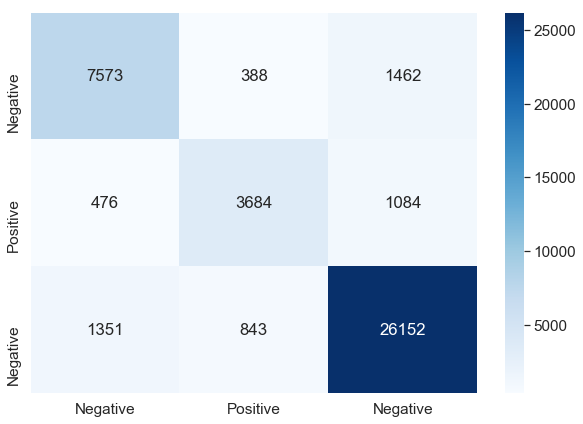

In [44]:
# Lets plot the confusion matrix 
import seaborn as sn

cm = confusion_matrix(y_test, y_pred)
# Create labels 
labels = ["Positive" if label == 0 else "Negative" for label in df.label.unique()]

sn.set(font_scale=1.4) # for font size 
df_cm = pd.DataFrame(cm, index = [i for i in labels], 
                    columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

In [48]:
%%time

# Implementing Random Forest Classifier 
from sklearn.ensemble import RandomForestClassifier

## build Random forest model
random_forest = RandomForestClassifier(n_estimators=100)

## Train the classifiers
# decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)


Wall time: 1h 43min 43s


In [31]:
# Create Predictions
rf_pred = random_forest.predict(X_test)

In [50]:
# Check the performance of the model
print('Random Forest Model')
print(classification_report(y_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive']))

#Graph our confusion matrix
rf_cm = confusion_matrix(y_test, rf_pred)
print("Random Forest - Confusion Matrix:\n", rf_cm)

# False and True
# tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()
print(confusion_matrix(y_test, rf_pred).ravel())

# (tn, fp, fn, tp)

# print(f"\nTrue Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

# Test the accuracy 
print ("\nAccuracy  score: ", round(accuracy_score(y_test, rf_pred), 3))

Random Forest Model
              precision    recall  f1-score   support

    Negative       0.97      0.74      0.84      9423
     Neutral       1.00      0.65      0.79      5244
    Positive       0.87      1.00      0.93     28346

   micro avg       0.90      0.90      0.90     43013
   macro avg       0.95      0.79      0.85     43013
weighted avg       0.91      0.90      0.89     43013

Random Forest - Confusion Matrix:
 [[ 6946     3  2474]
 [  129  3400  1715]
 [   95     1 28250]]
[ 6946     3  2474   129  3400  1715    95     1 28250]

Accuracy  score:  0.897


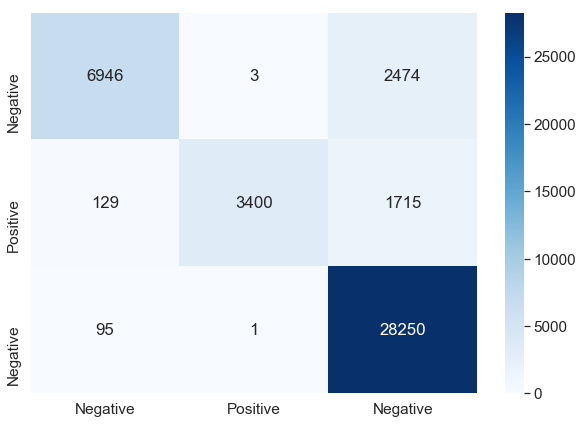

In [51]:
# Lets plot the confusion matrix 
import seaborn as sn

cm = confusion_matrix(y_test, rf_pred)
# Create labels 
labels = ["Positive" if label == 0 else "Negative" for label in df.label.unique()]

sn.set(font_scale=1.4) # for font size 
df_cm = pd.DataFrame(cm, index = [i for i in labels], 
                    columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

<h3><strong>Save the Model</strong></h3>

In [64]:
# Save the random forest model to disk
import pickle
filename = 'finalized_rf_model_tf_idf.sav'
pickle.dump(random_forest, open(filename, 'wb'))

In [65]:
# Save the decision tree model to disk
import pickle
filename = 'finalized_dt_model_tf_idf.sav'
pickle.dump(clf_model, open(filename, 'wb'))

In [ ]:
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)



<h3><strong>Run the model on new reviews</strong></h3>

In [45]:
# Let's test the model 
# Define a function to create a pipeline and run the predictions
def classify(text, classifier='None'):
    # Creating a sparse matrix 
    review_matrix = cv.transform([text])
    if classifier.lower() == 'decision tree':
        # Predict the outcome 
        y_prediction = clf_model.predict(review_matrix)
    elif classifier.lower() == 'random forest':
        y_prediction = random_forest.predict(review_matrix)
    else:
        return "Wrong/No classifier selected"       
    
    # Print the outcome
    print("Positive") if y_prediction else print("Negative")
    

In [46]:
# Positive test #1
review = "I feel better."
classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)

Positive


In [47]:
# Positive test #2
review = "I still have pain."
classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)

Positive


In [ ]:
# Negative test #1
review = "I feel sick."
classifier = "Decision Tree"
# classifier = "Random Forest"
classify(review, classifier)

In [ ]:
# Negative test #2
review = "I am very unhappy"
# classifier = "Decision Tree"
classifier = "Random Forest"
classify(review, classifier)

<h3><strong>Building Word Clouds</strong></h3>

In [52]:
# Getting the word count for each review type
# Positive
positive_reviews = df.review.loc[df.label == 1]

# Neutral
neutral_reviews = df.review.loc[df.label == 0]

# Negative
negative_reviews = df.review.loc[df.label == -1]

p_text, nu_text, n_text = " ".join(positive_reviews), " ".join(neutral_reviews), " ".join(negative_reviews)

print (f"There are {round(len(p_text)/1000000, 2)} million words in combination of all Positive reviews.")
print (f"There are {round(len(nu_text)/1000000, 2)} million words in the combination of all Neutral reviews.")
print (f"There are {round(len(n_text)/1000000, 2)} million words in the combination of all Negative reviews.")

There are 61.62 million words in combination of all Positive reviews.
There are 11.41 million words in the combination of all Neutral reviews.
There are 19.3 million words in the combination of all Negative reviews.


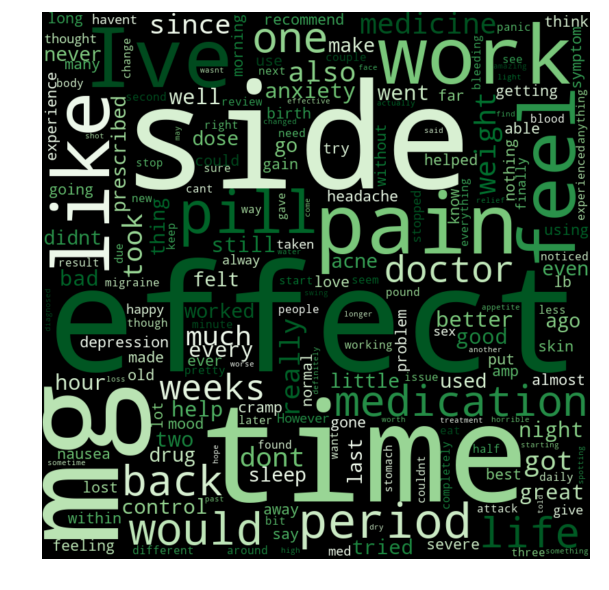

Wall time: 1min 28s


In [60]:
%%time

from wordcloud import WordCloud

# Create stopword list
stopwords = set(stopwords)

stopwords.update(['Im', 'day', 'days', 'week', 'month', 'months', 'year', 'years',
                  'started', 'taking', 'take', 'first', 'get', 'take'])

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800, stopwords=stopwords, 
                      background_color="black", collocations=False, colormap="Greens").generate(p_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

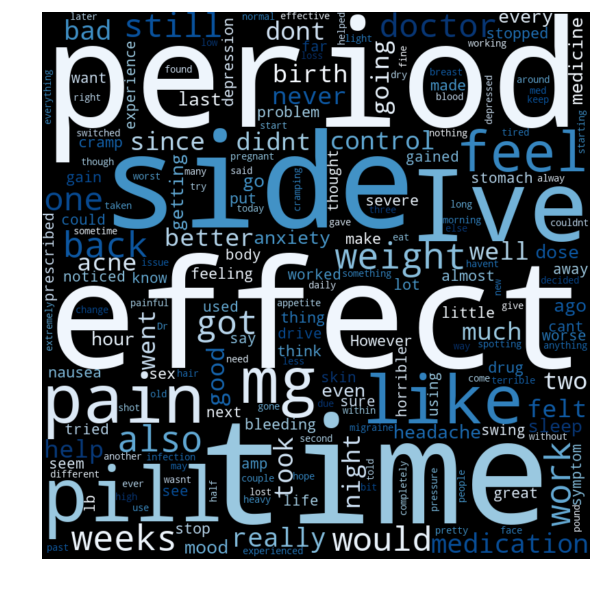

Wall time: 20.9 s


In [61]:
%%time

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800, stopwords=stopwords, 
                      background_color="black", collocations=False, colormap="Blues").generate(nu_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

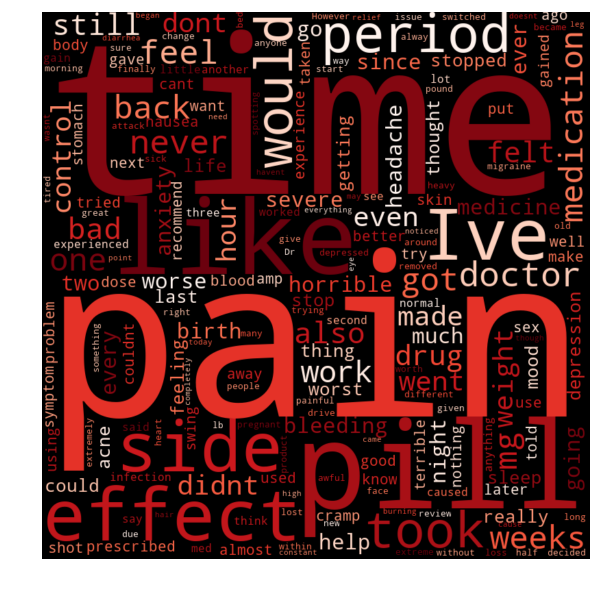

Wall time: 33.8 s


In [62]:
%%time

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800, stopwords=stopwords, 
                      background_color="black", collocations=False, colormap="Reds").generate(n_text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()